# Import Dataset

In [203]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download(handle="nicholasjhana/energy-consumption-generation-prices-and-weather")

print("Path to dataset files:", path)

path_energy = path + "/energy_dataset.csv"
path_weather = path + "/weather_features.csv"

# Load the datasets
import pandas as pd

energy_df = pd.read_csv(path_energy)
weather_df = pd.read_csv(path_weather)

Path to dataset files: /Users/pascaltrosch/.cache/kagglehub/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather/versions/1


## Convert Date-Variable to correct format

The "time"-variable is the identifying variable for both datasets in order to merge them later. Therefore, we need to convert them to the correct UTC-Format

In [204]:
energy_df['time'] = pd.to_datetime(energy_df['time'], utc=True)
energy_df = energy_df.set_index('time')

weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'], utc=True)
weather_df = weather_df.set_index('dt_iso')

energy_df.head()
weather_df.head()

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
dt_iso,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 00:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 01:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 02:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 03:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [205]:
# Replace total load actual with that rows total load forecast (Since thre are missing values)
energy_df['total load actual'].fillna(energy_df['total load forecast'], inplace=True)

/var/folders/9q/fdv3t0bs3vq9blwqqzpb7r240000gn/T/ipykernel_32004/2380757125.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  energy_df['total load actual'].fillna(energy_df['total load forecast'], inplace=True)


In [190]:
# Statistics of energy dataset
print("Energy dataset statistics:")
print(energy_df.describe())

# Statistics of weather dataset
print("Weather dataset statistics:")
print(weather_df.describe())

Energy dataset statistics:
       generation biomass  generation fossil brown coal/lignite  \
count        35045.000000                          35046.000000   
mean           383.513540                            448.059208   
std             85.353943                            354.568590   
min              0.000000                              0.000000   
25%            333.000000                              0.000000   
50%            367.000000                            509.000000   
75%            433.000000                            757.000000   
max            592.000000                            999.000000   

       generation fossil coal-derived gas  generation fossil gas  \
count                             35046.0           35046.000000   
mean                                  0.0            5622.737488   
std                                   0.0            2201.830478   
min                                   0.0               0.000000   
25%                          

# Merge two Datasets

Before the application of the pouplation weighted mean, we have to merge both datasets. If only applied to the energy-dataset, we would receive a wide-formatted-dataset (regarding cities), while the weather-dataset is in long format (regarding cities). To prevent mismatches while changing long- and wide-format, we merge both datasets as an inner-join, using the timestamp-variable as the relevant merging variable.

In [191]:
def join_energy_weather(energy_df, weather_df, how='inner'):
   
    # Ensure both indices are datetime
    energy_df.index = pd.to_datetime(energy_df.index)
    weather_df.index = pd.to_datetime(weather_df.index)
    
    # Join on index (timestamp)
    combined_df = energy_df.join(weather_df, how=how, lsuffix='_energy', rsuffix='_weather')
    
    return combined_df

# Join the datasets
combined_df = join_energy_weather(energy_df, weather_df, how='inner')

print(f"Energy data shape: {energy_df.shape}")
print(f"Weather df shape: {weather_df.shape}")
print(f"Combined data shape: {combined_df.shape}")
print(f"\nDate range: {combined_df.index.min()} to {combined_df.index.max()}")
print(f"\nColumns in combined dataset:")
print(combined_df.columns.tolist())


# Reset the index to move 'time' from the index to a regular column
combined_df = combined_df.reset_index()

# Ensure 'time' is in datetime format
combined_df['time'] = pd.to_datetime(combined_df['time'])

# Extract year, month, and hour from the 'time' column
combined_df['year'] = combined_df['time'].dt.year
combined_df['month'] = combined_df['time'].dt.month
combined_df['hour'] = combined_df['time'].dt.hour

# Reorder the columns to have 'year', 'month', and 'hour' right after 'time'
combined_df = combined_df[['time', 'year', 'month', 'hour'] + [col for col in combined_df.columns if col not in ['time', 'year', 'month', 'hour']]]



# Check the first few rows to verify the change
print(combined_df.head())

Energy data shape: (35064, 28)
Weather df shape: (178396, 16)
Combined data shape: (178396, 44)

Date range: 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00

Columns in combined dataset:
['generation biomass', 'generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage aggregated', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation marine', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind offshore', 'generation wind onshore', 'forecast solar day ahead', 'forecast wind offshore eday ahead', 'forecast wind onshore day ahead', 'total load forecast', 'total load actual', 'price day ahead', 'price actual', 

# Create Population Average Factors

The energy dataset only contains energy load data for all of spain, while the weather data contains data for the five largest cities (Madrid, Barcelona, Valencia, Sevilla and Bilbao). In order to compare energy load with weather data, we have to divide the energy load data according to the population of the cities, to get a rough average on the energy consumption of the population in those cities. This data is not 100% accurate, as it neglects extensive energy usage by large scale industries or higher power usage i.e. for street lighting. For the division, I use the population numbers of all five cities and divide the total energy load for spain through the respective factors for the cities.



In [192]:

# Populations of 5 major cities (Source: Wikipedia)
populations = {
    "Madrid": 3340176,
    "Barcelona": 1655956,
    "Valencia": 804121,
    "Sevilla": 654164,
    "Bilbao": 345235
}

# Population of Spain (Source: Wikipedia)
pop_spain = 48590000

# Calculate the factors for each city
city_factors = {}
for city, pop in populations.items():
    city_factors[city] = (pop / (pop_spain / 100)) / 100  # Calculating factor for each city

# Check the resulting factors
print(city_factors)


{'Madrid': 0.06874204568841326, 'Barcelona': 0.03408018110722371, 'Valencia': 0.016549104754064622, 'Sevilla': 0.013462934760238732, 'Bilbao': 0.007105062770117309}


In [193]:
# Error in City-Name "Barcelona" (blank space before the City name). Removal of the blank space for Barcelona

# Remove leading and trailing spaces from 'city_name' column
combined_df['city_name'] = combined_df['city_name'].str.strip()

# Now, check the dataframe to see if the spaces are removed
print(combined_df['city_name'].unique())  # To see unique city names and verify


['Valencia' 'Madrid' 'Bilbao' 'Barcelona' 'Seville']


# Add Population Factors as Rows to Dataset

The energy usage factors (percentage of the population of spain) are hence multiplied with the total load energy consumpiton of spain and added as a further column to the dataset, each row containing the energy load for the city at the timepoint of the row.



In [194]:
# Define city factors
city_factors = {
    "Madrid": pct_madrid,
    "Barcelona": pct_barcelona,
    "Valencia": pct_valencia,
    "Seville": pct_sevilla,
    "Bilbao": pct_bilbao
}

# Create a new column 'city_factor' based on 'city_name' by mapping the respective factors
combined_df['city_factor'] = combined_df['city_name'].map(city_factors)

# Now multiply 'total load actual' and 'total load forecast' by the city-specific factor
combined_df['total load actual adjusted'] = combined_df['total load actual'] * combined_df['city_factor']
combined_df['total load forecast adjusted'] = combined_df['total load forecast'] * combined_df['city_factor']

# Drop city_factor as it is no longer needed for further operations.
combined_df.drop(columns=['city_factor'], inplace=True)

# Print the adjusted dataframe
print(combined_df.head())

                       time  year  month  hour  generation biomass  \
0 2014-12-31 23:00:00+00:00  2014     12    23               447.0   
1 2014-12-31 23:00:00+00:00  2014     12    23               447.0   
2 2014-12-31 23:00:00+00:00  2014     12    23               447.0   
3 2014-12-31 23:00:00+00:00  2014     12    23               447.0   
4 2014-12-31 23:00:00+00:00  2014     12    23               447.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 329.0                                 0.0   
2                                 329.0                                 0.0   
3                                 329.0                                 0.0   
4                                 329.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0

# Compute population weighted mean for each timepoint

As the energy consumption for all five cities follows the same pattern as the nationwide energy consumption, we compute the population weighted mean for all five cities. This results in a mean value for all five cities, where energy consumption of bigger cities is weighted higher than for cities with smaller populations. We use the following formula for calculation:

**Weighted Mean** =  $\frac{\sum(\text{Population Factor})}{\sum (\text{Total Load Actual}\times\text{Population Factor})}$

The population weighted mean is computed for all five cities for each timepoint tin the dataset and added as a separate column to the dataset.

In [195]:
# Add the population factor for each city to the DataFrame
combined_df['population_factor'] = combined_df['city_name'].map(city_factors)

# Calculate the weighted total load actual for each timepoint
combined_df['weighted_load'] = combined_df['total load actual adjusted'] * combined_df['population_factor']

# Group by timepoint  and calculate the weighted mean
weighted_mean_per_timepoint = combined_df.groupby('time')['weighted_load'].sum() / combined_df.groupby('time')['population_factor'].sum()

# Print the result
print(weighted_mean_per_timepoint)

combined_df['weighted_population_mean'] = combined_df['time'].map(weighted_mean_per_timepoint)

# Print the updated dataframe to verify the new column
print(combined_df.head())

time
2014-12-31 23:00:00+00:00    1159.605744
2015-01-01 00:00:00+00:00    1113.787956
2015-01-01 01:00:00+00:00    1038.506086
2015-01-01 02:00:00+00:00     972.360365
2015-01-01 03:00:00+00:00     925.674643
                                ...     
2018-12-31 18:00:00+00:00    1400.251916
2018-12-31 19:00:00+00:00    1358.316991
2018-12-31 20:00:00+00:00    1282.304229
2018-12-31 21:00:00+00:00    1178.608935
2018-12-31 22:00:00+00:00    1117.122650
Length: 35064, dtype: float64
                       time  year  month  hour  generation biomass  \
0 2014-12-31 23:00:00+00:00  2014     12    23               447.0   
1 2014-12-31 23:00:00+00:00  2014     12    23               447.0   
2 2014-12-31 23:00:00+00:00  2014     12    23               447.0   
3 2014-12-31 23:00:00+00:00  2014     12    23               447.0   
4 2014-12-31 23:00:00+00:00  2014     12    23               447.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0             

# Explore new Dataset

In order to check whether everything was merged and computed in the right way, we explore the new dataset by getting a glimpse of a few observations and some plots which display the relevant and changed factors of the data frame.

In [196]:
combined_df.head()

,time,year,month,hour,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,...,clouds_all,weather_id,weather_main,weather_description,weather_icon,total load actual adjusted,total load forecast adjusted,population_factor,weighted_load,weighted_population_mean
0,2014-12-31 23:00:00+00:00,2014,12,23,447.0,329.0,0.0,4844.0,4821.0,162.0,...,0,800,clear,sky is clear,01n,420.099024,432.229518,0.016549,6.952263,1159.605744
1,2014-12-31 23:00:00+00:00,2014,12,23,447.0,329.0,0.0,4844.0,4821.0,162.0,...,0,800,clear,sky is clear,01n,1745.016830,1795.404749,0.068742,119.956027,1159.605744
2,2014-12-31 23:00:00+00:00,2014,12,23,447.0,329.0,0.0,4844.0,4821.0,162.0,...,0,800,clear,sky is clear,01,180.362018,185.570029,0.007105,1.281483,1159.605744
3,2014-12-31 23:00:00+00:00,2014,12,23,447.0,329.0,0.0,4844.0,4821.0,162.0,...,0,800,clear,sky is clear,01n,865.125397,890.106170,0.034080,29.483630,1159.605744
4,2014-12-31 23:00:00+00:00,2014,12,23,447.0,329.0,0.0,4844.0,4821.0,162.0,...,0,800,clear,sky is clear,01n,341.756599,351.624930,0.013463,4.601047,1159.605744


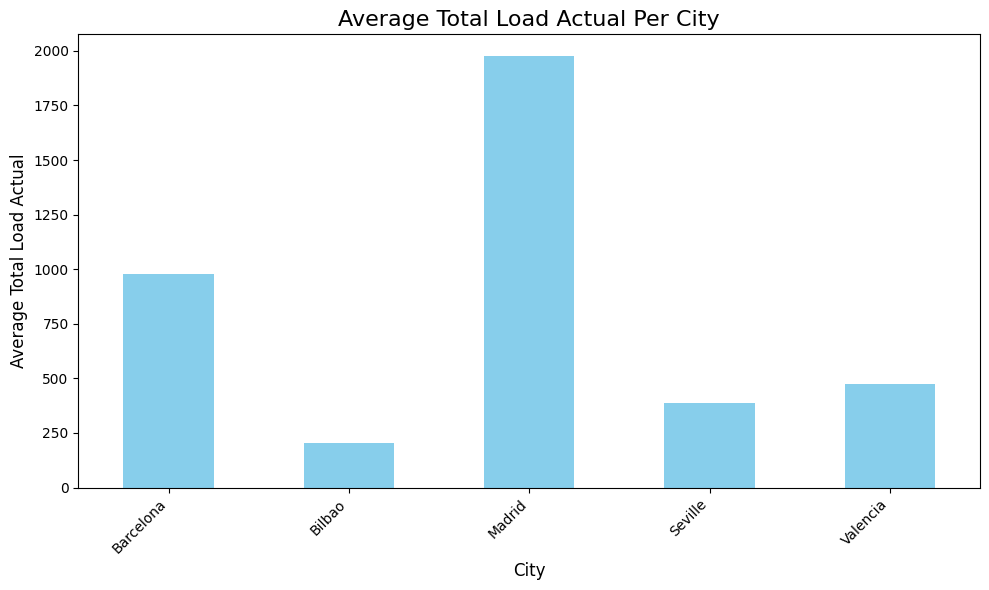

In [197]:
import matplotlib.pyplot as plt

# Calculate the average total load actual per city
avg_load_per_city = combined_df.groupby('city_name')['total load actual adjusted'].mean()

# Create the plot
plt.figure(figsize=(10, 6))
avg_load_per_city.plot(kind='bar', color='skyblue')

# Adding labels and title
plt.title('Average Total Load Actual Per City', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Average Total Load Actual', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


/var/folders/9q/fdv3t0bs3vq9blwqqzpb7r240000gn/T/ipykernel_32004/1750824694.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_df_2015['year_month'] = combined_df_2015['time'].dt.to_period('M')
/var/folders/9q/fdv3t0bs3vq9blwqqzpb7r240000gn/T/ipykernel_32004/1750824694.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_2015['year_month'] = combined_df_2015['time'].dt.to_period('M')


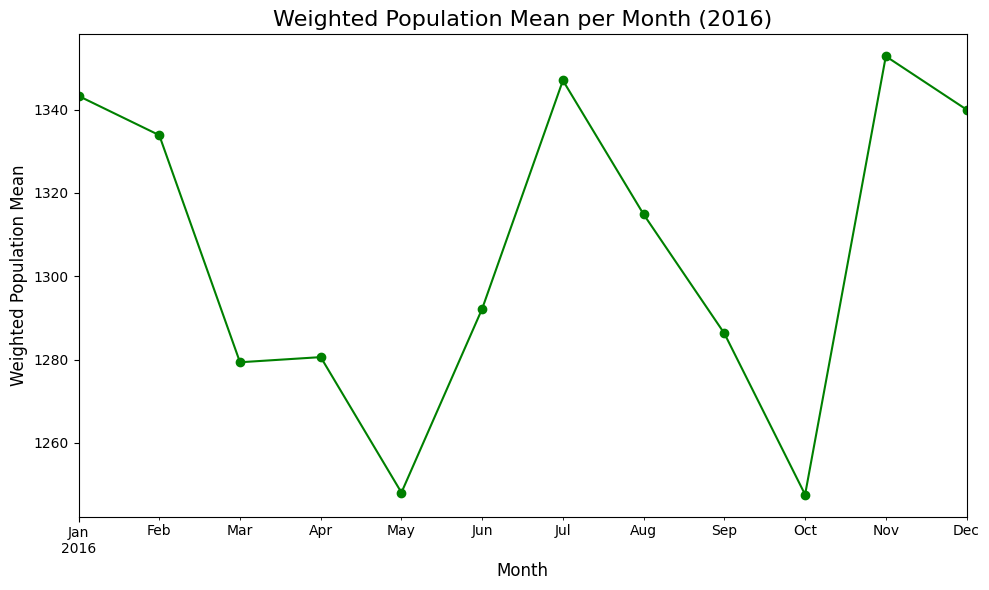

In [198]:
import matplotlib.pyplot as plt

# Ensure the 'time' column is in datetime format (if not already)
combined_df['time'] = pd.to_datetime(combined_df['time'])

# Filter the data for the year 2015
combined_df_2015 = combined_df[combined_df['time'].dt.year == 2016]

# Extract Year and Month
combined_df_2015['year_month'] = combined_df_2015['time'].dt.to_period('M')

# Group by 'year_month' and calculate the mean of 'weighted_population_mean' for each month
monthly_weighted_population_mean = combined_df_2015.groupby('year_month')['weighted_population_mean'].mean()

# Plot the time series of the weighted population mean for each month of 2015
plt.figure(figsize=(10, 6))
monthly_weighted_population_mean.plot(kind='line', color='green', marker='o')

# Adding labels and title
plt.title('Weighted Population Mean per Month (2016)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Weighted Population Mean', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


/var/folders/9q/fdv3t0bs3vq9blwqqzpb7r240000gn/T/ipykernel_32004/2117130557.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_df_2015_2018['year_month'] = combined_df_2015_2018['time'].dt.to_period('M')
/var/folders/9q/fdv3t0bs3vq9blwqqzpb7r240000gn/T/ipykernel_32004/2117130557.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_2015_2018['year_month'] = combined_df_2015_2018['time'].dt.to_period('M')


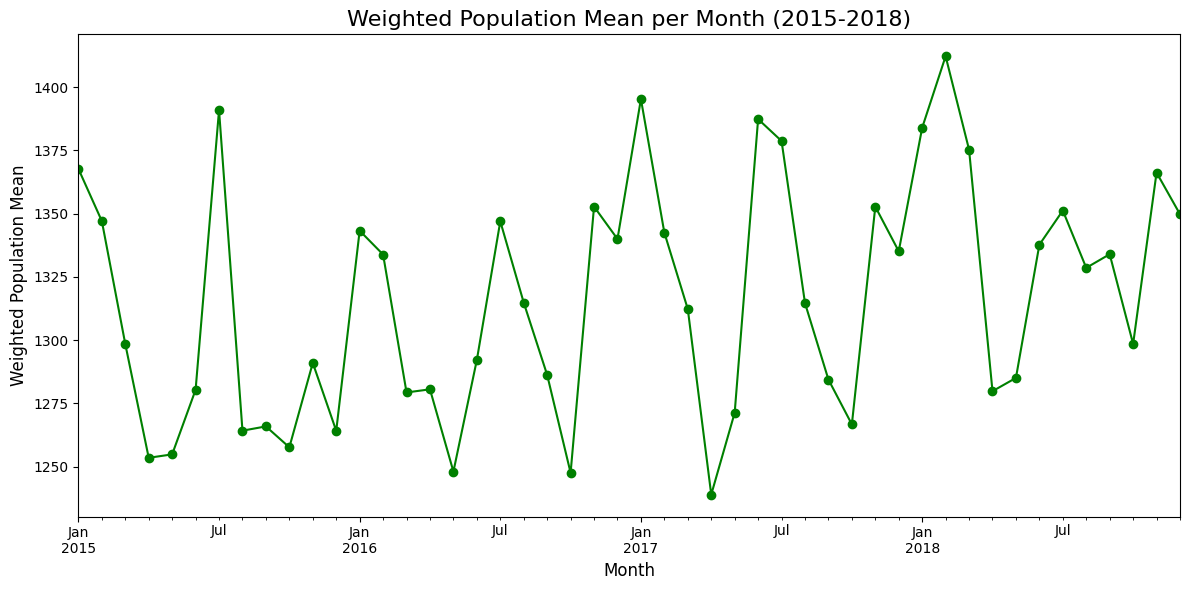

In [199]:
import matplotlib.pyplot as plt

# Ensure the 'time' column is in datetime format
combined_df['time'] = pd.to_datetime(combined_df['time'])

# Filter the data for the years 2015-2018
combined_df_2015_2018 = combined_df[(combined_df['time'].dt.year >= 2015) & (combined_df['time'].dt.year <= 2018)]

# Extract Year and Month
combined_df_2015_2018['year_month'] = combined_df_2015_2018['time'].dt.to_period('M')

# Group by 'year_month' and calculate the mean of 'weighted_population_mean' for each month
monthly_weighted_population_mean_all_years = combined_df_2015_2018.groupby('year_month')['weighted_population_mean'].mean()

# Plot the time series of the weighted population mean for each month from 2015 to 2018
plt.figure(figsize=(12, 6))
monthly_weighted_population_mean_all_years.plot(kind='line', color='green', marker='o')

# Adding labels and title
plt.title('Weighted Population Mean per Month (2015-2018)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Weighted Population Mean', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


/var/folders/9q/fdv3t0bs3vq9blwqqzpb7r240000gn/T/ipykernel_32004/358663301.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_df_2015_2018['year_month'] = combined_df_2015_2018['time'].dt.to_period('M')
/var/folders/9q/fdv3t0bs3vq9blwqqzpb7r240000gn/T/ipykernel_32004/358663301.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_2015_2018['year_month'] = combined_df_2015_2018['time'].dt.to_period('M')
/var/folders/9q/fdv3t0bs3vq9blwqqzpb7r240000gn/T/ipykernel_32004/358663301.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

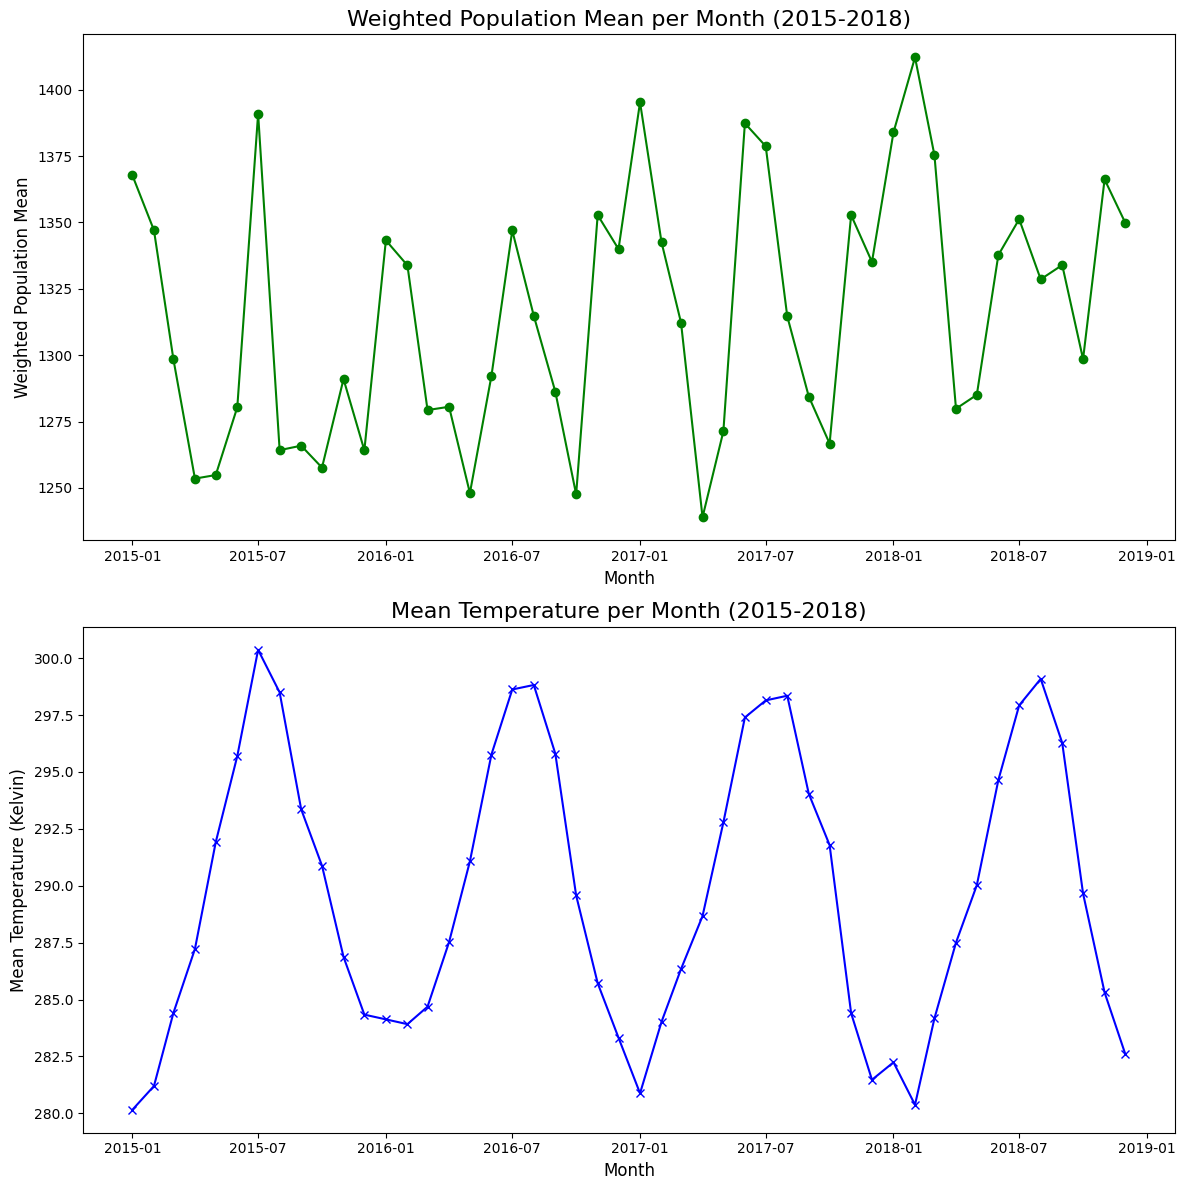

In [200]:


# Ensure the 'time' column is in datetime format
combined_df['time'] = pd.to_datetime(combined_df['time'])

# Filter the data for the years 2015-2018
combined_df_2015_2018 = combined_df[(combined_df['time'].dt.year >= 2015) & (combined_df['time'].dt.year <= 2018)]

# Extract Year and Month
combined_df_2015_2018['year_month'] = combined_df_2015_2018['time'].dt.to_period('M')

# Convert 'year_month' Periods to timestamps for plotting
combined_df_2015_2018['year_month_timestamp'] = combined_df_2015_2018['year_month'].dt.to_timestamp()

# Group by 'year_month' and calculate the mean of 'weighted_population_mean' for each month
monthly_weighted_population_mean_all_years = combined_df_2015_2018.groupby('year_month')['weighted_population_mean'].mean()

# Group by 'year_month' and calculate the mean of 'temp' (temperature) for each month
monthly_mean_temp_all_years = combined_df_2015_2018.groupby('year_month')['temp'].mean()

# Convert the groupby result indexes (Period) to timestamps for plotting
monthly_weighted_population_mean_all_years.index = monthly_weighted_population_mean_all_years.index.to_timestamp()
monthly_mean_temp_all_years.index = monthly_mean_temp_all_years.index.to_timestamp()

# Create subplots (two plots, one for weighted population mean and one for temperature)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot the first graph (Weighted Population Mean)
ax1.plot(monthly_weighted_population_mean_all_years, color='green', marker='o')
ax1.set_title('Weighted Population Mean per Month (2015-2018)', fontsize=16)
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Weighted Population Mean', fontsize=12)

# Plot the second graph (Mean Temperature)
ax2.plot(monthly_mean_temp_all_years, color='blue', marker='x')
ax2.set_title('Mean Temperature per Month (2015-2018)', fontsize=16)
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Mean Temperature (Kelvin)', fontsize=12)

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()


# Data Pipeline

In [208]:
import numpy as np


# Step 1: Data Ingestion
def load_data(file_path):
    return pd.read_csv(file_path)

# Step 2: Data Cleaning and Preprocessing
def preprocess_data(df):
    # Ensure the 'time' column is in datetime format
    df['time'] = pd.to_datetime(df['time'])
    
    # Extract Year, Month, and Hour from the 'time' column
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    df['hour'] = df['time'].dt.hour
    
    # Add population factor (assuming 'city_factors' is already defined)
    df['population_factor'] = df['city_name'].map(city_factors)
    
    # Calculate the weighted load
    df['weighted_load'] = df['total load actual'] * df['population_factor']
    
    return df

# Step 3: Calculate Aggregates (Weighted Mean)
def calculate_weighted_mean(df):
    df['year_month'] = df['time'].dt.to_period('M')
    
    # Group by year_month and calculate the weighted mean for total load actual
    monthly_weighted_mean = df.groupby('year_month')['weighted_load'].sum() / df.groupby('year_month')['population_factor'].sum()
    
    # Also calculate the mean temperature per month
    monthly_mean_temp = df.groupby('year_month')['temp'].mean()
    
    return monthly_weighted_mean, monthly_mean_temp

# Step 4: Visualization
def plot_results(weighted_mean, mean_temp):
    # Create subplots (two plots, one for weighted population mean and one for temperature)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot the first graph (Weighted Population Mean)
    ax1.plot(weighted_mean, color='green', marker='o')
    ax1.set_title('Weighted Population Mean per Month (2015-2018)', fontsize=16)
    ax1.set_xlabel('Month', fontsize=12)
    ax1.set_ylabel('Weighted Population Mean', fontsize=12)
    
    # Plot the second graph (Mean Temperature)
    ax2.plot(mean_temp, color='blue', marker='x')
    ax2.set_title('Mean Temperature per Month (2015-2018)', fontsize=16)
    ax2.set_xlabel('Month', fontsize=12)
    ax2.set_ylabel('Mean Temperature (°C)', fontsize=12)
    
    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

# Step 5: Save the Processed Data
def save_processed_data(df, output_path):
    df.to_csv(output_path, index=False)

# Step 6: Pipeline Execution
def data_pipeline(file_path, output_path):
    # Load data
    df = load_data(file_path)
    
    # Preprocess data
    df_cleaned = preprocess_data(df)
    
    # Calculate aggregates (weighted mean and temperature)
    weighted_mean, mean_temp = calculate_weighted_mean(df_cleaned)
    
    # Plot results
    plot_results(weighted_mean, mean_temp)
    
    # Optionally, save the processed data to a file
    save_processed_data(df_cleaned, output_path)
    
    print("Pipeline execution completed successfully!")

# Save data
file_path = 'data/processed_data_pop_mean.csv'  # Update with actual path
output_path = 'data/processed_data_pop_mean.csv'  # Specify output file path

# Run the pipeline
data_pipeline(file_path, output_path)


FileNotFoundError: [Errno 2] No such file or directory: 'data/processed_data_pop_mean.csv'